# Explore a benchmark model

This notebook explores the prediction accuracy for a regression model predicting ERA5 skin temperature.

It was trained on a year of data from 2016, validated on 2017 and predictions were made for 2019.

The input features were MODIS LST + static surface fields (e.g. orography) from ERA5.


### TL;DR numbers:

Averaged over all data points (in space/time) for the prediction set:

* Bias = 0.07 K
* MAE = 3.34 K
* MSE = 20.0 K



---

# 1. Load the model

In [ ]:
path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/NV_Benchmark_1/'

#### What were the input features?

In [20]:
import json
with open(path_to_model+'configuration.json') as f:
    config=json.load(f)
    print ('Features trained on:')
    display(config['train']['training_features'])
    print ('Target variable:')
    display(config['train']['target_variable'])

Features trained on:


['MODIS_LST',
 'slt_v15',
 'sdfor_v15',
 'sdor_v15',
 'cvl_v15',
 'lsm_v15',
 'isor_v15',
 'tvl_v15',
 'tvh_v15',
 'cvh_v15',
 'si10_v15',
 'anor_v15',
 'cl_v15',
 'dl_v15',
 'z_v15',
 'slor_v15']

Target variable:


'skt'

# 2. Evaluate the model

In [38]:
import pandas as pd
def load_predictions(path):
    
    """
    Load the predictions, calculate bias/MSE/MAE and surface averaged values
    """

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_bias'] = df.skt - df.predictions
    df['model_mae']  = abs(df.skt - df.predictions)
    df['model_mse']  = (df.skt - df.predictions)**2
    
    
    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_bias'].mean(), df['model_bias'].median(),df['model_bias'].std())
    print("Mean/Median/Std prediction MAE:",  df['model_mae'].mean(),  df['model_mae'].median(), df['model_mae'].std())
    print("Mean/Median/Std prediction MSE:",  df['model_mse'].mean(),  df['model_mse'].median(), df['model_mse'].std())
    print ('-------------------------------------------------------------------------------------------')

    
    return df



import seaborn as sns
def plot_distribution(df,z):
    
    """
    Plot distribution of quantitty `z`
    """

    
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )


    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    sns.histplot(df[z], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,element='step')

    # Config
    ax1.axvline(0,c='0.5', linestyle='--')


    plt.show()



import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 
def global_plot(df,z,projection,vmin,vmax,cmap,absolute_values,logscale,title,markersize,savefig,cbar_label):
    
    
    """
    Plot the value `z` from the dataframe `df` on the globe with a `projection`.
    Note this is just a scatter plot, rather than e.g. a contourf()
    """
        
    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=projection)
    cax = fig.add_axes([0.32, 0.11, 0.4, 0.0125])

    #Get data
    try:
        x = df.longitude
        y = df.latitude
    except: # different sources call lat/lon different things
        x = df.longitude_ERA
        y = df.latitude_ERA

    z1 = df[z]
    if absolute_values:
        z1 = abs(z1)
        if vmin < 0:
            vmin = 0 # dont need negative vmins if plotting absolute values
    
    
    #Normalize, colorbars
    if vmin is None:
        vmin = min(z1)
    if vmax is None:
        vmax = max(z1)
        

    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    
    
    
    
    
    
    #Scatter points
    sc = ax.scatter(x,y,transform=ccrs.PlateCarree(), #Always PlateCarree
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    #Formatting
    cax.tick_params(labelsize=30)
    cax.set_xlabel(cbar_label,fontsize=34)

    ax.set_title(title)    
    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio


    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)   
        
 

In [24]:
predictions = load_predictions(path_to_model_1)                                                             # Load predictions from file, surface some metrics
predictions_yearly_average =predictions.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()    # Average predictions over the year. We will plot these averaged values below

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.07068443 -0.11642456 4.4770613
Mean/Median/Std prediction MAE: 3.3435102 2.5789185 2.9782531
Mean/Median/Std prediction MSE: 20.04907 6.6508203 40.775253
-------------------------------------------------------------------------------------------


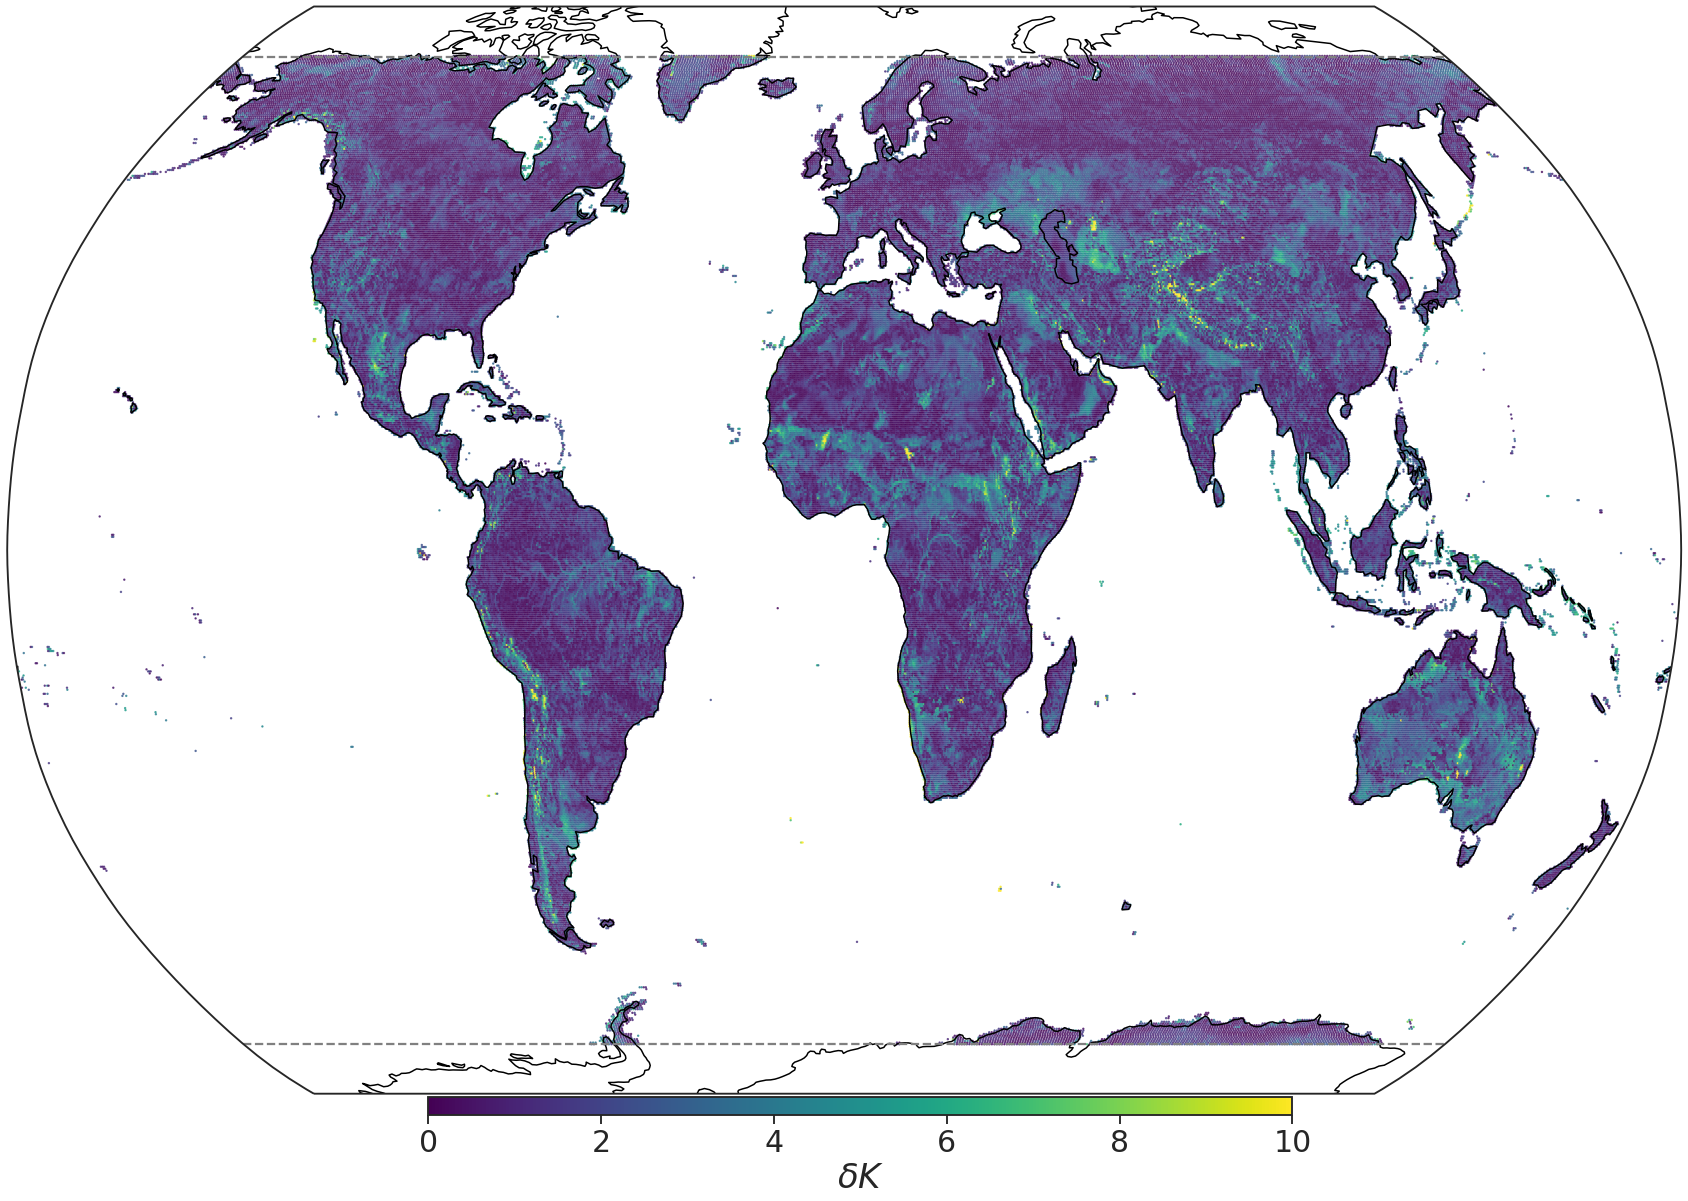

In [31]:
global_plot(predictions_yearly_average,
            'model_bias',
            projection=ccrs.Robinson(), #ccrs.PlateCarree() , ccrs.Robinson()
            vmin=0,vmax=+10,
            cmap=plt.cm.viridis,
            absolute_values = True, 
            logscale=False,
            title=None,
            markersize=2,
            savefig=None,
            cbar_label=r'$\delta K$')

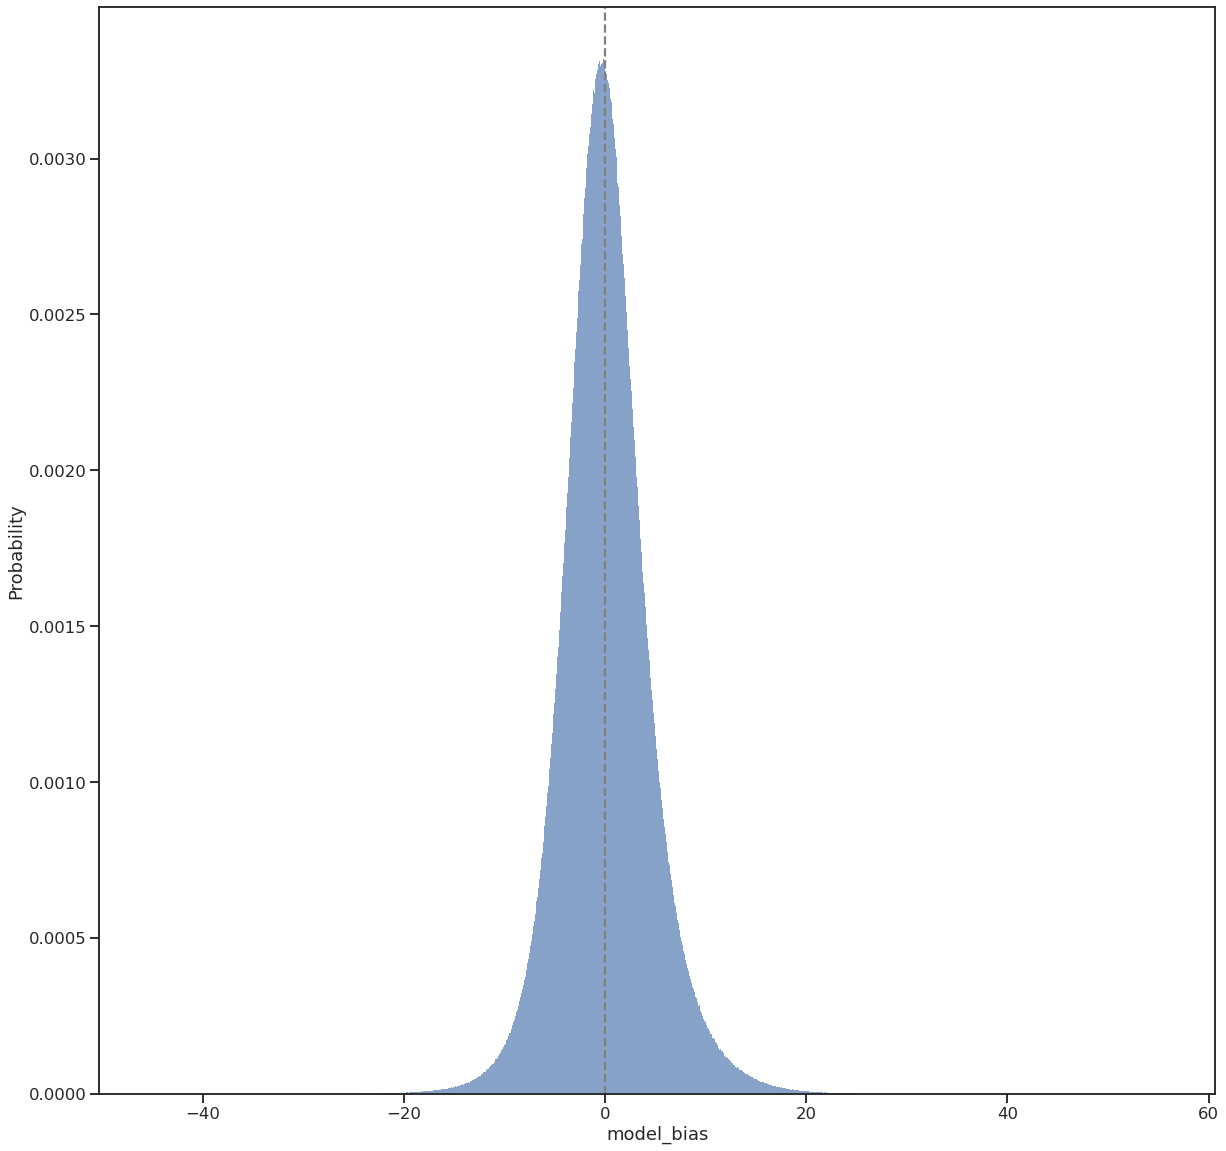

In [39]:
plot_distribution(predictions,'model_bias')

---

In [1]:
import os


path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/NV_Benchmark_1/'
file_name = path_to_model + 'predictions.parquet'
file_stats = os.stat(file_name)

print(file_stats)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')


os.stat_result(st_mode=33188, st_ino=12570087245109065127, st_dev=59, st_nlink=1, st_uid=26591, st_gid=18029, st_size=719297879, st_atime=1663567233, st_mtime=1663567236, st_ctime=1663567236)
File Size in Bytes is 719297879
File Size in MegaBytes is 685.9759130477905
